# Toy model for GP studies

## Alexandra Semposki

### Date: 02 September 2024

Here, we attempt to play with a simple toy model for a GP, with some amount of slow curvature, that should help illuminate our confusion with $\chi$EFT.

In [1]:
# import packages needed
import numpy as np
import matplotlib.pyplot as plt
import sys
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import ConstantKernel, RBF

sys.path.append('../src')

from gp_utils import GaussianProcessRegressor2dNoise

## 1. Set up the problem

First, let's design the curve that we want to test. We'll do this by plotting some points, randomized off of a true function that we have put into the `true_function` function below. 

In [2]:
def true_function(x):
    return -np.exp(0.2*x) * np.cos(0.8*x)

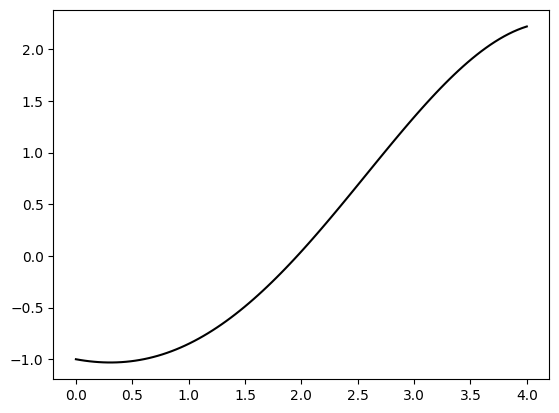

In [3]:
x = np.linspace(0.0, 4.0, 100)  # 6.0

plt.plot(x, true_function(x), 'k')

Now let's sample from this to get our dataset. We can do this by adding noise to the data that we grab, too, so it has some variation to it.

In [4]:
x_data = np.linspace(0.0,4.0,5) # 6.0
true_data = true_function(x_data)
y_data = true_function(x_data)#, dy=0.15)

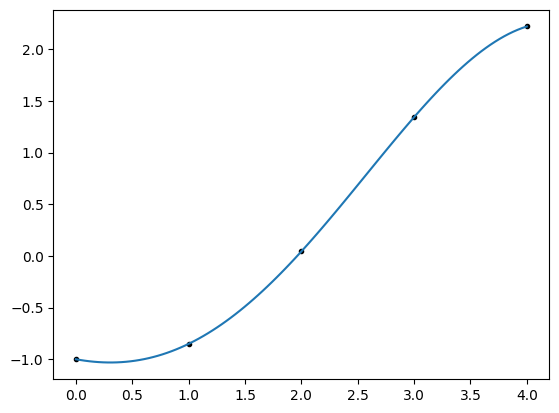

In [5]:
plt.plot(x_data, y_data, 'k.')
plt.plot(x, true_function(x))

Now we can simply take the result of the above plot and add some error bars to it, to symbolize errors.

In [6]:
np.random.seed(0)
y_err = np.diag(np.random.random(len(x_data)) * (0.35*np.eye(len(x_data))))

<ErrorbarContainer object of 3 artists>

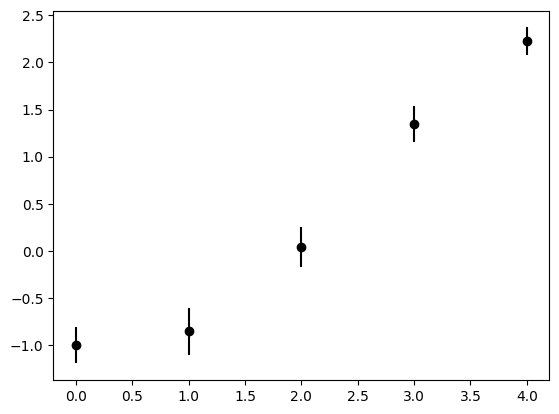

In [7]:
plt.plot(x_data, y_data, 'k.')
plt.errorbar(x_data, y_data, y_err, color='black', fmt='o')

## Adding a Gaussian process

Now we fit with a Gaussian process to get the curve, and then we'll try to get that same curve back using another GP, to see how things change.

1.59**2 * RBF(length_scale=2.18)


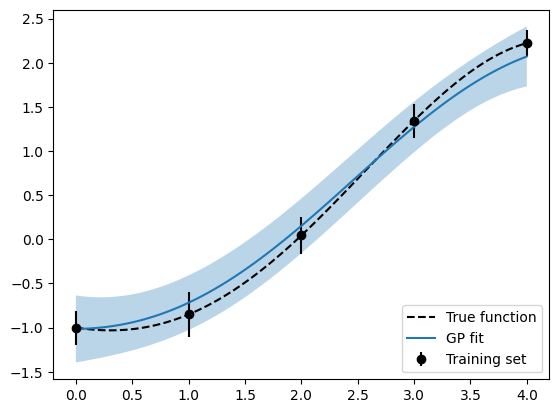

In [8]:
# calling sklearn 
kernel1 = ConstantKernel(1.0) * RBF(length_scale=1.0)
gp = GaussianProcessRegressor(
    kernel = kernel1,
    alpha = y_err,
)

x_train = x_data.reshape(-1,1)
y_train = y_data.reshape(-1,1)

# fit the GP using the training data
gp.fit(x_train, y_train) 

# show the kernel parameters
print(gp.kernel_)

# predict using this GP on new prediction data
y_predict, y_std = gp.predict(x.reshape(-1,1), return_std=True)
_, y_cov = gp.predict(x.reshape(-1,1), return_cov=True)

# now plot the results
plt.plot(x, true_function(x), 'k', linestyle='dashed', label=r'True function')
plt.errorbar(x_data, y_data, y_err, fmt='o', color='k', label=r'Training set')
plt.plot(x, y_predict, label=r'GP fit')
plt.fill_between(x, y_predict-y_std, y_predict+y_std, alpha=0.3)
plt.legend(loc='lower right')
plt.show()

## Fitting this with another GP

Now we'd like to see a GP that is able to recover this error band and general shape. We'll need data points from this GP, to try this out.

First, let's just take some data from the GP, using the mean and the covariance matrix. This will tell us if we cannot recover the mean easily using data from along it or not.

In [9]:
# pull training data from the GP's prediction set (the only access to direct values we have)
x_tr4 = x[25::15]
y_tr4 = y_predict[25::15]
y_trstd4 = y_std[25::15]
y_trcov4 = y_cov[25::15, 25::15]

# optional (chicken) nugget for regularization of Cholesky Decomposition
nugget = 1e-08*np.eye(len(x_tr4))

### Case A: Using the same GP hyperparameters as the true GP and a fixed kernel

1.59**2 * RBF(length_scale=2.18)


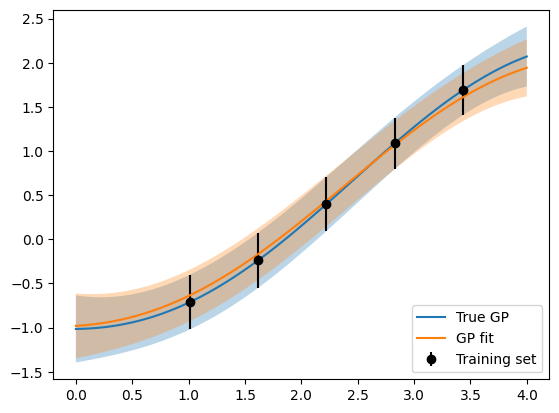

In [10]:
# train a new GP on this data and compare to the original
kernel2 = ConstantKernel(1.59**2.0, constant_value_bounds='fixed') * \
RBF(length_scale=2.18, length_scale_bounds='fixed')
gp2 = GaussianProcessRegressor2dNoise(
    kernel = kernel2,
    alpha = y_trcov4 + nugget,
)

gp2.fit(x_tr4.reshape(-1,1), y_tr4.reshape(-1,1), priors=False)

print(gp2.kernel_)

# predict at the same ol' array (no reason not to for now)
y_pred4, y_std4 = gp2.predict(x.reshape(-1,1), return_std = True)
_, y_cov4 = gp2.predict(x.reshape(-1,1), return_cov = True)

# plot the result over the original GP
plt.plot(x, y_predict, label=r'True GP')
plt.errorbar(x_tr4, y_tr4, y_trstd4, fmt='o', color='k', label=r'Training set')
plt.fill_between(x, y_predict-y_std, y_predict+y_std, alpha=0.3)
plt.plot(x, y_pred4, label=r'GP fit')
plt.fill_between(x, y_pred4-y_std4, y_pred4+y_std4, alpha=0.3)
plt.legend(loc='lower right')
plt.show()

In [11]:
# now let's check the width differences in the above error bands
width_true = (y_predict+y_std) - (y_predict-y_std)
width_7 = (y_pred4+y_std4) - (y_pred4-y_std4)

#print('Relative error:\n', (np.abs((width_7 - width_true))/width_true)*100)
print('\nMaximum error difference: ', np.max((np.abs((width_7 - width_true))/width_true)*100))


Maximum error difference:  6.431593920775401


OK, now let's see what happens if we instead use many more points than 7. Let's try using 12 of the total 100 in the original set.

In [12]:
# pull training data from the GP's prediction set (the only access to direct values we have)
x_tr50 = x[4::7]
y_tr50 = y_predict[4::7]
y_trstd50 = y_std[4::7]
y_trcov50 = y_cov[4::7, 4::7]

print('Number of data in training set: ', len(x_tr50))

# optional (chicken) nugget for regularization of Cholesky Decomposition
nugget50 = 1e-08*np.eye(len(x_tr50))

Number of data in training set:  14


1.59**2 * RBF(length_scale=2.18)


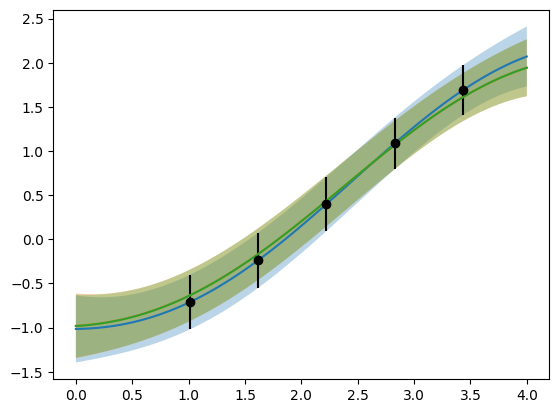

In [13]:
# train a new GP on this data and compare to the original
gp3 = GaussianProcessRegressor2dNoise(
    kernel = kernel2,
    alpha = y_trcov50 + nugget50,
)

gp3.fit(x_tr50.reshape(-1,1), y_tr50.reshape(-1,1), priors=False)

print(gp3.kernel_)

# predict at the same ol' array (no reason not to for now)
y_pred50, y_std50 = gp3.predict(x.reshape(-1,1), return_std = True)
_, y_cov50 = gp3.predict(x.reshape(-1,1), return_cov = True)

# plot the result over the original GP
plt.plot(x, y_predict)
plt.fill_between(x, y_predict-y_std, y_predict+y_std, alpha=0.3)
plt.errorbar(x_tr4, y_tr4, y_trstd4, fmt='o', color='k')
plt.plot(x, y_pred4)
plt.fill_between(x, y_pred4-y_std4, y_pred4+y_std4, alpha=0.3)
plt.plot(x, y_pred50)
plt.fill_between(x, y_pred50-y_std50, y_pred50+y_std50, alpha=0.3)
plt.show()

In [14]:
# now let's check the width differences in the above error bands
width_50 = (y_pred50+y_std50) - (y_pred50-y_std50)

#print('Relative error:\n', (np.abs((width_25 - width_true))/width_true)*100)
print('\nMaximum error difference: ', np.max((np.abs((width_7 - width_true))/width_true)*100))
print('Error difference between GP fits: ', np.max((np.abs(width_7 - width_50))/(width_7+width_50)*100))


Maximum error difference:  6.431593920775401
Error difference between GP fits:  1.2399364897402958


### Case B: Using delta function hyperpriors and a variable kernel

Now we'll try using the kernel that is optimized using the log marginal likelihood, with no set hyperpriors.

1.59**2 * RBF(length_scale=2.7)


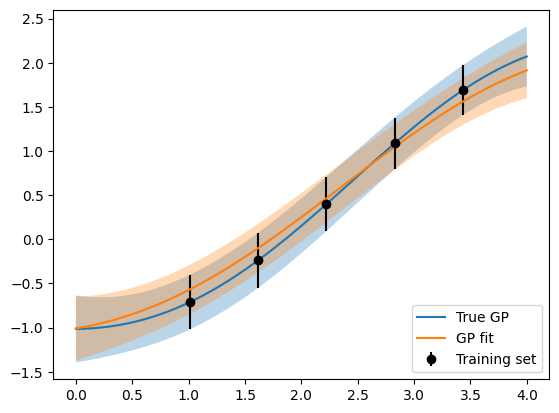

In [15]:
# train a new GP on this data and compare to the original
kernel3 = ConstantKernel(1.59**2.0) * \
RBF(length_scale=2.18)
gp4 = GaussianProcessRegressor2dNoise(
    kernel = kernel3,
    alpha = y_trcov4 + nugget,
)

gp4.fit(x_tr4.reshape(-1,1), y_tr4.reshape(-1,1), priors=False)

print(gp4.kernel_)

# predict at the same ol' array (no reason not to for now)
y_predb, y_stdb = gp4.predict(x.reshape(-1,1), return_std = True)
_, y_covb = gp4.predict(x.reshape(-1,1), return_cov = True)

# plot the result over the original GP
plt.plot(x, y_predict, label=r'True GP')
plt.errorbar(x_tr4, y_tr4, y_trstd4, fmt='o', color='k', label=r'Training set')
plt.fill_between(x, y_predict-y_std, y_predict+y_std, alpha=0.3)
plt.plot(x, y_predb, label=r'GP fit')
plt.fill_between(x, y_predb-y_stdb, y_predb+y_stdb, alpha=0.3)
plt.legend(loc='lower right')
plt.show()

Check the error differences now.

In [16]:
width_b = (y_predb+y_stdb) - (y_predb-y_stdb)

print('\nMaximum error difference: ', np.max((np.abs((width_b - width_true))/width_true)*100))


Maximum error difference:  11.682971214533389


OK, now the error between the true GP and the fitted one is more significant! Let's do the same test we did previously and train on 25 points in the curve to see what happens. 

/Users/alexandra/Documents/EOSBMM/buqeyenm/notebooks/../src/gp_utils.py:523: UserWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  warnings.warn(warning_msg) #ConvergenceWarning, stacklevel=2)  # commenting out for now


1.5**2 * RBF(length_scale=2.74)


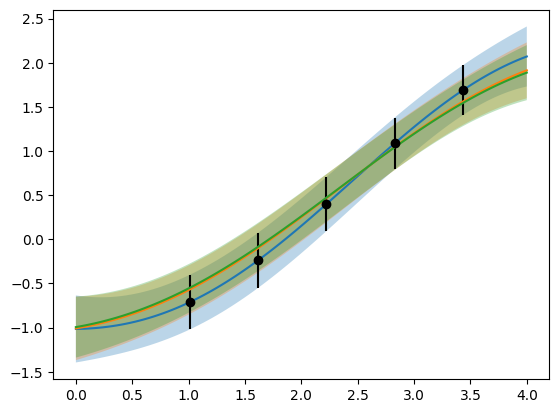

In [17]:
# train a new GP on this data and compare to the original
gp5 = GaussianProcessRegressor2dNoise(
    kernel = kernel3,
    alpha = y_trcov50 + nugget50,
    n_restarts_optimizer=100,
)

gp5.fit(x_tr50.reshape(-1,1), y_tr50.reshape(-1,1), priors=False)

print(gp5.kernel_)

# predict at the same ol' array (no reason not to for now)
y_predb50, y_stdb50 = gp5.predict(x.reshape(-1,1), return_std = True)
_, y_covb50 = gp5.predict(x.reshape(-1,1), return_cov = True)

# plot the result over the original GP
plt.plot(x, y_predict)
plt.fill_between(x, y_predict-y_std, y_predict+y_std, alpha=0.3)
plt.errorbar(x_tr4, y_tr4, y_trstd4, fmt='o', color='k')
plt.plot(x, y_predb, label=r'GP fit 1')
plt.fill_between(x, y_predb-y_stdb, y_predb+y_stdb, alpha=0.3)
plt.plot(x, y_predb50, label=r'GP fit 2')
plt.fill_between(x, y_predb50-y_stdb50, y_predb50+y_stdb50, alpha=0.3)
plt.show()

In [18]:
# now let's check the width differences in the above error bands
width_b50 = (y_predb50+y_stdb50) - (y_predb50-y_stdb50)

#print('Relative error:\n', (np.abs((width_25 - width_true))/width_true)*100)
print('\nMaximum error difference: ', np.max((np.abs((width_b - width_true))/width_true)*100))
print('Error difference between GP fits: ', np.max((np.abs(width_b - width_b50))/(width_b+width_50)*100))


Maximum error difference:  11.682971214533389
Error difference between GP fits:  1.884394089781824


## Chiral EFT look-a-like investigation

Now we will check that, if we use errors that are not randomly distributed, that we see a reduction in the error bands when we fit with another GP.

[[0.1        0.99033895 0.75837865 0.62898184 0.95279166]
 [0.99033895 0.15       0.32001715 0.87265066 0.68748828]
 [0.75837865 0.32001715 0.2        0.27354203 0.21550768]
 [0.62898184 0.87265066 0.27354203 0.45       0.94737059]
 [0.95279166 0.68748828 0.21550768 0.94737059 0.5       ]]


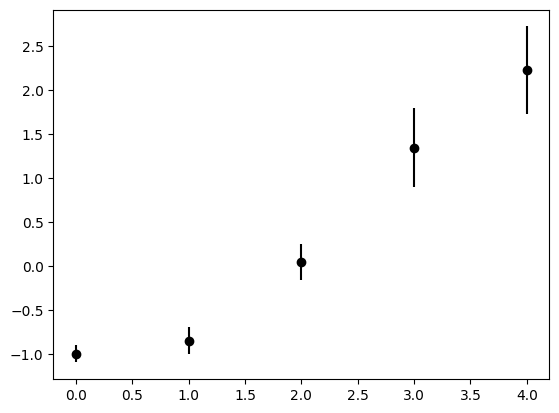

In [19]:
# new error band creation
y_err_chiral = np.array([0.1, 0.15, 0.2, 0.45, 0.5])
plt.plot(x_data, y_data, 'k.')
plt.errorbar(x_data, y_data, y_err_chiral, color='black', fmt='o')

cov_matrix = np.random.rand(5,5)
for i in range(len(x_data)):
    for j in range(len(x_data)):
        if i == j:
            cov_matrix[i,j] = y_err_chiral[i]
ell = np.tril(cov_matrix)
cov_full_matrix = ell + ell.T
for i in range(len(x_data)):
    for j in range(len(x_data)):
        if i == j:
            cov_full_matrix[i,j] = y_err_chiral[i]
            
print(cov_full_matrix)

1.38**2 * RBF(length_scale=2.01)


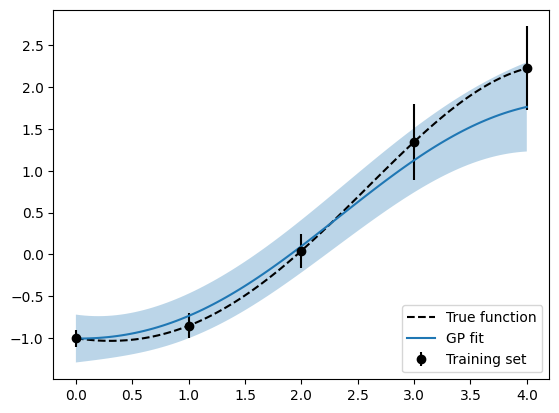

In [20]:
# now fit a true GP again
kernel1 = ConstantKernel(1.0) * RBF(length_scale=1.0)
gp = GaussianProcessRegressor(
    kernel = kernel1,
    alpha = y_err_chiral,
)

x_train = x_data.reshape(-1,1)
y_train = y_data.reshape(-1,1)

# fit the GP using the training data
gp.fit(x_train, y_train) 

# show the kernel parameters
print(gp.kernel_)

# predict using this GP on new prediction data
y_predict, y_std = gp.predict(x.reshape(-1,1), return_std=True)
_, y_cov = gp.predict(x.reshape(-1,1), return_cov=True)

# now plot the results
plt.plot(x, true_function(x), 'k', linestyle='dashed', label=r'True function')
plt.errorbar(x_data, y_data, y_err_chiral, fmt='o', color='k', label=r'Training set')
plt.plot(x, y_predict, label=r'GP fit')
plt.fill_between(x, y_predict-y_std, y_predict+y_std, alpha=0.3)
plt.legend(loc='lower right')
plt.show()

It is already difficult to fit a GP to this data, with the error bars the way that they are displayed. This makes some sense considering the effort that went into the truncation errors in `gsum`, and how this was a model of the truncation error, not the mean, and that the coefficients are modelled by the GP, not the entire curve. There is a lot of structure to this type of curve that it may be very difficult to completely capture using an RBF kernel.

In [21]:
# pull training data from the GP's prediction set (the only access to direct values we have)
x_tr4 = x[::25]
y_tr4 = y_predict[::25]
y_trstd4 = y_std[::25]
y_trcov4 = y_cov[::25, ::25]

# optional (chicken) nugget for regularization of Cholesky Decomposition
nugget = 1e-08*np.eye(len(x_tr4))

1.38**2 * RBF(length_scale=2.01)


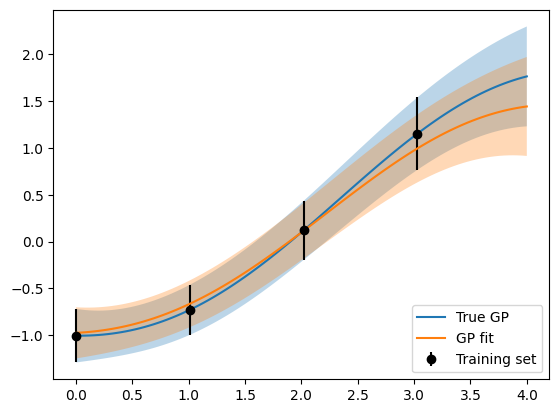


Maximum error difference:  6.6852142714591345


In [22]:
# train a new GP on this data and compare to the original
kernel2 = ConstantKernel(1.38**2.0, constant_value_bounds='fixed') * \
RBF(length_scale=2.01, length_scale_bounds='fixed')
gp2 = GaussianProcessRegressor2dNoise(
    kernel = kernel2,
    alpha = y_trcov4 + nugget,
)

gp2.fit(x_tr4.reshape(-1,1), y_tr4.reshape(-1,1), priors=False)

print(gp2.kernel_)

# predict at the same ol' array (no reason not to for now)
y_pred4, y_std4 = gp2.predict(x.reshape(-1,1), return_std = True)
_, y_cov4 = gp2.predict(x.reshape(-1,1), return_cov = True)

# plot the result over the original GP
plt.plot(x, y_predict, label=r'True GP')
plt.errorbar(x_tr4, y_tr4, y_trstd4, fmt='o', color='k', label=r'Training set')
plt.fill_between(x, y_predict-y_std, y_predict+y_std, alpha=0.3)
plt.plot(x, y_pred4, label=r'GP fit')
plt.fill_between(x, y_pred4-y_std4, y_pred4+y_std4, alpha=0.3)
plt.legend(loc='lower right')
plt.show()

# now let's check the width differences in the above error bands
width_true = (y_predict+y_std) - (y_predict-y_std)
width_7 = (y_pred4+y_std4) - (y_pred4-y_std4)

#print('Relative error:\n', (np.abs((width_7 - width_true))/width_true)*100)
print('\nMaximum error difference: ', np.max((np.abs((width_7 - width_true))/width_true)*100))

Number of data in training set:  20
1.38**2 * RBF(length_scale=2.01)


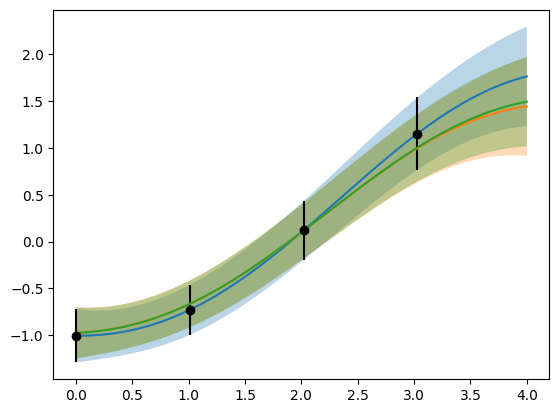


Maximum error difference:  6.6852142714591345
Error difference between GP fits:  5.025505219863142


In [23]:
# pull training data from the GP's prediction set (the only access to direct values we have)
x_tr50 = x[4::5]
y_tr50 = y_predict[4::5]
y_trstd50 = y_std[4::5]
y_trcov50 = y_cov[4::5, 4::5]

print('Number of data in training set: ', len(x_tr50))

# optional (chicken) nugget for regularization of Cholesky Decomposition
nugget50 = 1e-08*np.eye(len(x_tr50))

# train a new GP on this data and compare to the original
gp3 = GaussianProcessRegressor2dNoise(
    kernel = kernel2,
    alpha = y_trcov50 + nugget50,
)

gp3.fit(x_tr50.reshape(-1,1), y_tr50.reshape(-1,1), priors=False)

print(gp3.kernel_)

# predict at the same ol' array (no reason not to for now)
y_pred50, y_std50 = gp3.predict(x.reshape(-1,1), return_std = True)
_, y_cov50 = gp3.predict(x.reshape(-1,1), return_cov = True)

# plot the result over the original GP
plt.plot(x, y_predict)
plt.fill_between(x, y_predict-y_std, y_predict+y_std, alpha=0.3)
plt.errorbar(x_tr4, y_tr4, y_trstd4, fmt='o', color='k')
plt.plot(x, y_pred4)
plt.fill_between(x, y_pred4-y_std4, y_pred4+y_std4, alpha=0.3)
plt.plot(x, y_pred50)
plt.fill_between(x, y_pred50-y_std50, y_pred50+y_std50, alpha=0.3)
plt.show()

# now let's check the width differences in the above error bands
width_50 = (y_pred50+y_std50) - (y_pred50-y_std50)

#print('Relative error:\n', (np.abs((width_25 - width_true))/width_true)*100)
print('\nMaximum error difference: ', np.max((np.abs((width_7 - width_true))/width_true)*100))
print('Error difference between GP fits: ', np.max((np.abs(width_7 - width_50))/(width_7+width_50)*100))

1.2**2 * RBF(length_scale=2.33)


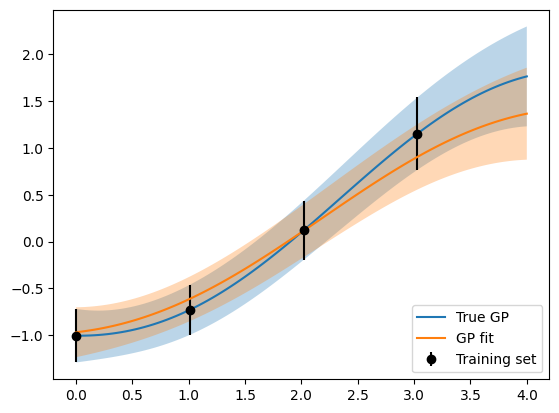


Maximum error difference:  11.447197722086177


In [24]:
# train a new GP on this data and compare to the original
kernel3 = ConstantKernel(1.59**2.0) * \
RBF(length_scale=2.18)
gp4 = GaussianProcessRegressor2dNoise(
    kernel = kernel3,
    alpha = y_trcov4 + nugget,
)

gp4.fit(x_tr4.reshape(-1,1), y_tr4.reshape(-1,1), priors=False)

print(gp4.kernel_)

# predict at the same ol' array (no reason not to for now)
y_predb, y_stdb = gp4.predict(x.reshape(-1,1), return_std = True)
_, y_covb = gp4.predict(x.reshape(-1,1), return_cov = True)

# plot the result over the original GP
plt.plot(x, y_predict, label=r'True GP')
plt.errorbar(x_tr4, y_tr4, y_trstd4, fmt='o', color='k', label=r'Training set')
plt.fill_between(x, y_predict-y_std, y_predict+y_std, alpha=0.3)
plt.plot(x, y_predb, label=r'GP fit')
plt.fill_between(x, y_predb-y_stdb, y_predb+y_stdb, alpha=0.3)
plt.legend(loc='lower right')
plt.show()

width_b = (y_predb+y_stdb) - (y_predb-y_stdb)

print('\nMaximum error difference: ', np.max((np.abs((width_b - width_true))/width_true)*100))

/Users/alexandra/Documents/EOSBMM/buqeyenm/notebooks/../src/gp_utils.py:523: UserWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  warnings.warn(warning_msg) #ConvergenceWarning, stacklevel=2)  # commenting out for now


1.14**2 * RBF(length_scale=2.53)


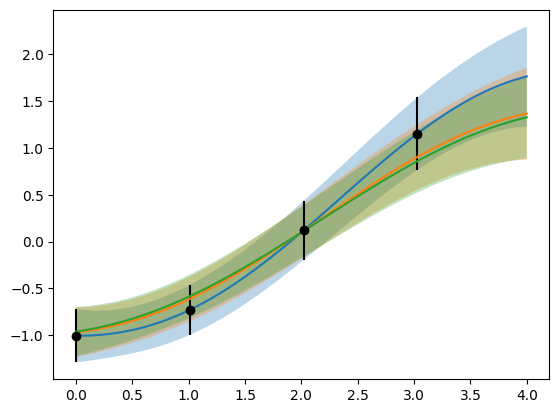

In [25]:
# train a new GP on this data and compare to the original
gp5 = GaussianProcessRegressor2dNoise(
    kernel = kernel3,
    alpha = y_trcov50 + nugget50,
    n_restarts_optimizer=100,
)

gp5.fit(x_tr50.reshape(-1,1), y_tr50.reshape(-1,1), priors=False)

print(gp5.kernel_)

# predict at the same ol' array (no reason not to for now)
y_predb50, y_stdb50 = gp5.predict(x.reshape(-1,1), return_std = True)
_, y_covb50 = gp5.predict(x.reshape(-1,1), return_cov = True)

# plot the result over the original GP
plt.plot(x, y_predict)
plt.fill_between(x, y_predict-y_std, y_predict+y_std, alpha=0.3)
plt.errorbar(x_tr4, y_tr4, y_trstd4, fmt='o', color='k')
plt.plot(x, y_predb, label=r'GP fit 1')
plt.fill_between(x, y_predb-y_stdb, y_predb+y_stdb, alpha=0.3)
plt.plot(x, y_predb50, label=r'GP fit 2')
plt.fill_between(x, y_predb50-y_stdb50, y_predb50+y_stdb50, alpha=0.3)
plt.show()

In [26]:
# now let's check the width differences in the above error bands
width_b50 = (y_predb50+y_stdb50) - (y_predb50-y_stdb50)

#print('Relative error:\n', (np.abs((width_25 - width_true))/width_true)*100)
print('\nMaximum error difference: ', np.max((np.abs((width_b - width_true))/width_true)*100))
print('Error difference between GP fits: ', np.max((np.abs(width_b - width_b50))/(width_b50+width_b)*100))


Maximum error difference:  11.447197722086177
Error difference between GP fits:  5.664006442354643


This does indeed show that the GP can reduce its error bands if trained in different places or with different numbers of data. However, again, this isn't a great proxy for chiral EFT since chiral would be trained using a covariance matrix, to obtain the proper shape of the truncation error bands.